# **Neutral-Atom Quantum Computers**

Source: Pennylane blog

>How you know you have produced a good quantum computer (QC)?

Well the answer which is at present folowed by almost everyone is the infamous DiVicenzo's criteria. 

DiVincenzo criteria

1. The QC must be **well characterized and has scalable qubits**. The physical systems found in nature are not two level. So, the QC must have the capability of isolating two levels of the atomic units and must form a cluster of many such systems.
2. The QC must be capable of **initializing** the qubits in a state repeatedly with very high fidelity.
3. Qubits must show **long coherence time**.
4. QC must be able to perform the **universal set of gates**.
5. As pointed out before **measurements** is the primary organ of QC. Thus, a QC must accurately measure the states of any of the choosen qubits.

So, we need to build computers, which satisfy the above criterias but what you choose to start? Like in classical case you start with a bunch of transistors. Here what will be your transistors??

Let's choose the most common quantum systems we know of, **neutral atoms**.
Now neutral atom has how many energy levels?

INFINITE!!!!!!!!!!!!!!!!!

So we have a task now. Keep the neutral atom bounded to only two energy levels.

### Task1: 



Quantum circuit topologies:

Creating an eiffel tower circuit topology with the neutral atoms. [Data from [Pasqal](https://www.pasqal.com/)]

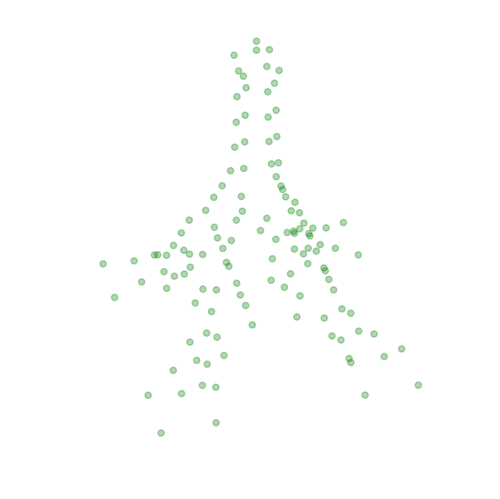

In [1]:
import numpy as np
import matplotlib.pyplot as plt

coords = np.loadtxt("../data/Eiffel_tower_data.dat")
xs = coords[:,0]
ys = coords[:,1]
zs = coords[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 15)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-40, 10)
plt.axis('off')
ax.scatter(xs, ys, zs, c='green',alpha=0.3)
plt.show()

Choose 9 out of 126 qubits (evenly placed)

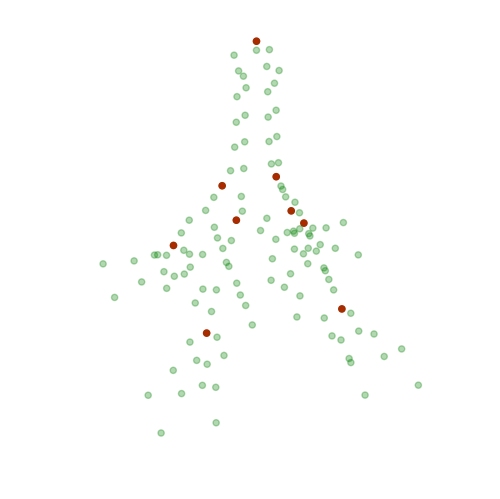

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 15)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-40, 10)
plt.axis('off')
ax.scatter(xs, ys, zs, c='g', alpha=0.3)

base_mask = [3, 7, 11, 15]
qubit_mask = [48, 51, 60, 63, 96, 97, 98, 99, 125]
input_coords = coords[base_mask]  # we'll need this for a plot later
qubit_coords = coords[qubit_mask]

subset_xs = qubit_coords[:, 0]
subset_ys = qubit_coords[:, 1]
subset_zs = qubit_coords[:, 2]
ax.scatter(subset_xs, subset_ys, subset_zs, c='r', alpha=1.0)
plt.show();

Convert to circ qubits:

Our next step will be to convert these datapoints into objects that Cirq understands as qubits. For neutral-atom devices in Cirq, we can use the ThreeDQubit class, which carries information about the three-dimensional arrangement of the qubits.

Now, neutral-atom devices come with some physical restrictions. Specifically, in a particular three-dimensional configuration, qubits that are too distant from one another can’t easily interact. Instead, there is a notion of a control radius; any atoms which are within the system’s control radius can interact with one another. Qubits separated by a distance larger than the control radius cannot interact.

In order to allow our Eiffel tower qubits to interact with one another more easily, we will artificially scale some dimensions when placing the atoms.

In [3]:
from cirq_pasqal import ThreeDQubit
xy_scale = 1.5
z_scale = 0.75
qubits = [ThreeDQubit(xy_scale * x, xy_scale * y, z_scale * z)
                for x, y, z in qubit_coords]

To simulate a neutral-atom quantum computation, we can use the "cirq.pasqal" device, available via the PennyLane-Cirq plugin. We will need to provide this device with the ThreeDQubit object that we created above. We also need to instantiate the device with a fixed control radius.

In [4]:
import pennylane as qml

num_wires = len(qubits)
control_radius = 32.4
dev = qml.device("cirq.pasqal", control_radius=control_radius,
                 qubits=qubits, wires=num_wires)

We will now make a variational circuit out of the Eiffel tower configuration from above. Each of the 9 qubits we are using can be thought of as a single wire in a quantum circuit. We will cause these qubits to interact by applying a sequence of two-qubit gates. Specifically, the circuit consists of several stages:

Input classical data is converted into quantum information at the first (lowest) vertical level of qubits. In this example, our classical data will be simple bit strings, which we can embed by using single-qubit bit flips (a simple data-embedding strategy).

For each corner of the tower, CNOTs are enacted between the first- and second-level qubits.

All qubits from the second level interact with a single “peak” qubit using a parametrized controlled-rotation operation. The free parameters of our variational circuit enter here.

The output of our circuit is determined via a Pauli-Z measurement on the final “peak” qubit.

That’s a few things to keep track of, so let’s show the circuit via a three-dimensional image:

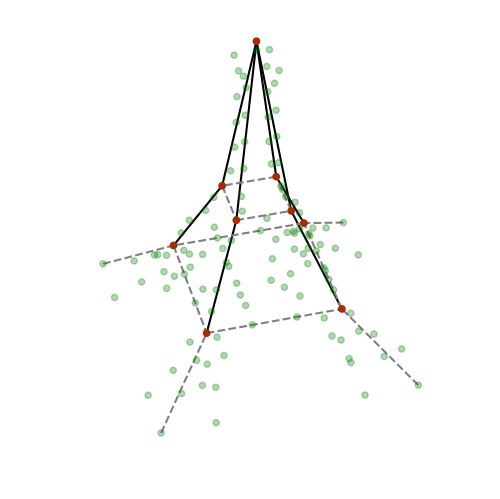

In [5]:
first_lvl_coords = qubit_coords[:4]
second_lvl_coords = qubit_coords[4:8]
peak_coords = qubit_coords[8]

input_x, input_y, input_z = [input_coords[:, idx]
                             for idx in range(3)]
second_x, second_y, second_z = [first_lvl_coords[:, idx]
                                for idx in range(3)]
third_x, third_y, third_z = [second_lvl_coords[:, idx]
                             for idx in range(3)]
peak_x, peak_y, peak_z = peak_coords

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 15)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-40, 10)
plt.axis('off')

ax.scatter(xs, ys, zs, c='g', alpha=0.3)
ax.scatter(subset_xs, subset_ys, subset_zs, c='r', alpha=1.0);

# Two-qubit gates between second and third levels
for corner in range(4):
    ax.plot(xs=[second_x[corner], third_x[corner]],
            ys=[second_y[corner], third_y[corner]],
            zs=[second_z[corner], third_z[corner]],
            c='k');

# Two-qubit gates between third level and peak
for corner in range(4):
    ax.plot(xs=[third_x[corner], peak_x],
            ys=[third_y[corner], peak_y],
            zs=[third_z[corner], peak_z],
            c='k');

# Additional lines to guide the eye
for corner in range(4):
    ax.plot(xs=[input_x[corner], second_x[corner]],
            ys=[input_y[corner], second_y[corner]],
            zs=[input_z[corner], second_z[corner]],
            c='grey', linestyle='--');
    ax.plot(xs=[second_x[corner], second_x[(corner + 1) % 4]],
            ys=[second_y[corner], second_y[(corner + 1) % 4]],
            zs=[second_z[corner], second_z[(corner + 1) % 4]],
            c='grey', linestyle='--');
    ax.plot(xs=[third_x[corner], third_x[(corner + 1) % 4]],
            ys=[third_y[corner], third_y[(corner + 1) % 4]],
            zs=[third_z[corner], third_z[(corner + 1) % 4]],
            c='grey', linestyle='--');

plt.show();